# LASSO Regresion on covid-19 cases in New York, Massachusetts and Connecticut

## Load modulues

In [1]:
%matplotlib inline
import os
import requests
import urllib.parse
from zipfile import ZipFile
import io
from datetime import datetime, timedelta


import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display

locator = mdates.AutoDateLocator()

formatter = mdates.ConciseDateFormatter(locator)

sns.set_style("whitegrid")
GAMMA = 1/7.5

events = {}

df_dict = {}

if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('figs'):
    os.mkdir('figs')

/home/andres/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Important dates

## Get data

### New York

In [2]:
dsname = 'New York'

# API information
# https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e

if not os.path.isfile('data/ny.csv'):
    url = urllib.parse.quote("https://health.data.ny.gov/resource/xdss-u53e.csv/?$limit=5000")
    #
    dfs = []
    offset = 0
    while offset >=0:
        url = "https://health.data.ny.gov/resource/xdss-u53e.csv/?$limit=5000&$offset={}".format(offset)
        df = pd.read_csv(url, usecols=['test_date', 'total_number_of_tests', 'new_positives'])
        dfs.append(df)
        if len(df)==5000:
            offset += 5000 
        else:
            offset = -1
    dfraw = pd.concat(dfs)
    #'test_date=2020-03-15T00:00:00.000'

    dfraw = dfraw.rename(columns={'new_positives': 'Positives', 'total_number_of_tests': 'Tests', 'test_date': 'date'})
    print(len(dfraw))
    dfraw['date'] = pd.to_datetime(dfraw['date'])
    #counties = (df.groupby('date')['Tests']>0).count()
    df = dfraw.groupby('date').sum()
    print(df.head(1))
    df['Odds'] = df.Positives / (df.Tests - df.Positives)
    df['Date'] = pd.to_datetime(df.index)
    df.to_csv('data/ny.csv')
    df = df[df['Date'] >= '2020-03-15']
    # last date of full NYS PAUSE
    df = df[df['Date'] <= '2020-05-15']

else:
    df = pd.read_csv('data/ny.csv')
    df['date'] =pd.to_datetime(df['date'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('date')
    df = df[df['Date'] >= '2020-03-15']
    # last date of full NYS PAUSE
    df = df[df['Date'] <= '2020-05-15']
df = df[['Date', 'Tests', 'Positives', 'Odds']]
df_dict[dsname] = df

# 03/17/2020 close of gyms, restaurants and bars, movie theaters, mass gathering up to 50. https://www.governor.ny.gov/news/amid-lack-federal-direction-governor-cuomo-governor-murphy-and-governor-lamont-announce
bars = pd.to_datetime('03-16-2020 20:00', dayfirst=False)
# 03/18/2020 school clousure http://www.nysed.gov/news/2020/state-education-department-issues-updated-guidance-schools-regarding-novel-coronavirus
schools = pd.to_datetime('03-18-2020 20:00', dayfirst=False)

# https://www.governor.ny.gov/news/amid-ongoing-covid-19-pandemic-governor-cuomo-announces-deployment-1000-bed-hospital-ship-usns
# 03/20/2020 00:00 50% of the workforce
workforce_50 = pd.to_datetime('03-20-2020 20:00', dayfirst=False)
# 03/22/2020 20:00 ny_pause 
ny_pause = pd.to_datetime('22-03-2020 00:00', dayfirst=True)
# CDC masks https://www.npr.org/sections/goatsandsoda/2020/04/10/829890635/why-there-so-many-different-guidelines-for-face-masks-for-the-public
masks_cdc = pd.to_datetime('03-04-2020 00:00', dayfirst=True)
mask_employers = pd.to_datetime('12-04-2020 00:00', dayfirst=True)
mask_public = pd.to_datetime('17-04-2020 00:00', dayfirst=True)

events_list = [bars, schools, workforce_50, ny_pause, masks_cdc, mask_employers, mask_public]
events['New York'] = events_list


df.tail()

,Date,Tests,Positives,Odds
date,,,,
2020-05-11,2020-05-11,20463,1430,0.075133
2020-05-12,2020-05-12,33794,2176,0.068822
2020-05-13,2020-05-13,39850,2390,0.063801
2020-05-14,2020-05-14,39291,2762,0.075611
2020-05-15,2020-05-15,40669,2419,0.063242


## Connecticut

In [3]:
dsname = 'Connecticut'
# reopening phase 1 may 20
# https://portal.ct.gov/Coronavirus/Covid-19-Knowledge-Base/Reopen-plan

# all APIs avaliables
# https://data.ct.gov/stories/s/COVID-19-data/wa3g-tfvc/#covid-19-testing-data

if not os.path.isfile('data/connecticut.csv'):
    dfs = []
    offset = 0
    while offset >=0:
        url = 'https://data.ct.gov/resource/qfkt-uahj.csv?$limit=5000&$offset={}'.format(offset)
        df = pd.read_csv(url)
        dfs.append(df)
        if len(df)==5000:
            offset += 5000 
        else:
            offset = -1
    dfcounty = pd.concat(dfs)
    dfcounty = dfcounty.rename(columns={'number_of_positives': 'Positives', 'number_of_tests': 'Tests', 'number_of_negatives': 'Negatives'})
    dfcounty['Tests'] = dfcounty['Tests'] - dfcounty['number_of_indeterminates']
    # print(len(dfcounty))
    dfcounty['date'] = pd.to_datetime(dfcounty['date'])
    df = dfcounty.groupby('date').sum()
    #df = df.diff()
    df['Odds'] = df.Positives / df.Negatives
    df['Date'] = pd.to_datetime(df.index)
    df.to_csv('data/connecticut.csv')
else:
    df = pd.read_csv('data/connecticut.csv')
    df = df.set_index('date')
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.to_datetime(df.index)
df = df.sort_index()
#print(df[['Tests', 'Positives', 'Odds']].head(30))

df = df[df['Date'] <= '2020-05-19']
df = df[df['Date'] > '2020-03-19']
df = df[['Date', 'Tests', 'Positives', 'Odds']]
#print(df.head())
df_dict[dsname] = df
# intervention dates
# https://portal.ct.gov/Coronavirus/Pages/Emergency-Orders-issued-by-the-Governor-and-State-Agencies
# 03/12/2020 no gatherings with more than 250
large_gatherings = pd.to_datetime('03-12-2020 00:00', dayfirst=False)
schools = pd.to_datetime('03-17-2020 00:00', dayfirst=False)
bars = pd.to_datetime('03-16-2020 20:00', dayfirst=False)

malls = pd.to_datetime('03-19-2020 20:00', dayfirst=False)
workforce100 = pd.to_datetime('03-23-2020 20:00', dayfirst=False)
# CDC masks https://www.npr.org/sections/goatsandsoda/2020/04/10/829890635/why-there-so-many-different-guidelines-for-face-masks-for-the-public
masks_cdc = pd.to_datetime('04-03-2020 00:00', dayfirst=False)
mask_public = pd.to_datetime('04-20-2020 00:00', dayfirst=False)

event_list = [large_gatherings, bars, schools, malls, workforce100, masks_cdc,  mask_public]
events[dsname] = event_list

df.tail()


,Date,Tests,Positives,Odds
date,,,,
2020-05-15,2020-05-15,7492,650,0.095001
2020-05-16,2020-05-16,3756,315,0.091543
2020-05-17,2020-05-17,2607,210,0.087610
2020-05-18,2020-05-18,6759,703,0.116083
2020-05-19,2020-05-19,6971,793,0.128359


## Massachusetts

In [4]:
dsname = 'Massachusetts'
# web site with data
# https://www.mass.gov/info-details/covid-19-response-reporting
yesterday = datetime.today() - timedelta(0)
if  not os.path.isfile('data/massachusetts.csv'):
    #yesterday = datetime.today() - timedelta(10)
    yesterday_str = datetime.strftime(yesterday, '%B-%d-%Y').lower()
    fn = 'data/{}.zip'.format(dsname)
    
    url2 = 'https://www.mass.gov/doc/covid-19-raw-data-june-10-2020/download'
    url = 'https://www.mass.gov/doc/covid-19-raw-data-{}/download'.format(yesterday_str)
    print(url)
    print(url2)
    myfile = requests.get(url, allow_redirects=True)
    #open(fn, 'wb').write(myfile.content)
    zf = ZipFile(io.BytesIO(myfile.content))
    csvf = zf.open('TestingByDate.csv')
    df = pd.read_csv(csvf)

    # https://www.mass.gov/doc/covid-19-raw-data-may-27-2020/download
    #df = pd.read_csv('data/massachusetts/COVID-19-Dashboard-Files-05-24-2020/TestingByDate.csv',
    #                 usecols=['Date', 'New', 'Positive'])

    df = df.rename(columns={'Molecular Positive New': 'Positives', 'Molecular New': 'Tests'})
    df['Negatives'] = df.Tests - df.Positives
    df = df.query('Tests>100')
    df['date'] = pd.to_datetime(df['Date'])
    df= df.set_index('date')
    df['Date'] = pd.to_datetime(df['Date'])
    df['Odds'] = df.Positives / df.Negatives
    #df = df[df['Date']<'2020-05-15']
    df.to_csv('data/massachusetts.csv')
else:
    df = pd.read_csv('data/massachusetts.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
df = df[df['Date']<'2020-05-18']
#df = df[df['Date']>'2020-03-15']
df = df[df['Date']>'2020-03-14']
df = df[['Date', 'Tests', 'Positives', 'Odds']]
df_dict[dsname] = df

# https://www.mass.gov/info-details/covid-19-state-of-emergency
schools = pd.to_datetime('03-22-2020 00:00', dayfirst=False)
saty_at_home = pd.to_datetime('03-24-2020 00:00', dayfirst=False)
masks_cdc = pd.to_datetime('04-03-2020 00:00', dayfirst=False)
masks_public = pd.to_datetime('05-06-2020 00:00', dayfirst=False)

event_list = [schools, saty_at_home, masks_cdc, masks_public]
events[dsname] = event_list
df_dict[dsname] = df

## Michigan

In [5]:
dsname = 'Michigan'
if not os.path.isfile('data/michigan.csv'):
    df = pd.read_excel('https://www.michigan.gov/documents/coronavirus/Diagnostic_Tests_by_Result_and_County_2020-06-16_693915_7.xlsx')
    df['date'] = pd.to_datetime(df['MessageDate'])
    df = df[df['COUNTY']!='Correctional']
    df = df.groupby('date').sum()
    df['Date'] = df.index
    df.to_csv('data/michigan.csv')
else:
    df = pd.read_csv('data/michigan.csv', index_col='date', parse_dates=['date', 'Date'])
df = df.rename(columns={'Negative': 'Negatives', 'Positive': 'Positives','Total': 'Tests'})
df['Odds'] = df.Positives / df.Negatives
df = df[df['Date']>'2020-03-16']
df = df[df['Date']<'2020-05-18']
df_dict[dsname] = df

# https://www.michigan.gov/whitmer/0,9309,7-387-90499_90705-522626--,00.html
saty_at_home = pd.to_datetime('03-24-2020 00:00', dayfirst=False)
masks_cdc = pd.to_datetime('04-03-2020 00:00', dayfirst=False)
# https://www.michigan.gov/whitmer/0,9309,7-387-90499-526896--,00.html
masks_public = pd.to_datetime('04-24-2020 00:00', dayfirst=False)
event_list = [saty_at_home, masks_cdc, masks_public]
events[dsname] = event_list

## Rhode Island

In [6]:
dsname = 'Rhode Island'
#https://docs.google.com/spreadsheets/d/1n-zMS9Al94CPj_Tc3K7Adin-tN9x1RSjjx2UzJ4SV7Q/edit#gid=590763272
url = 'https://docs.google.com/spreadsheets/d/1n-zMS9Al94CPj_Tc3K7Adin-tN9x1RSjjx2UzJ4SV7Q/export?format=csv&id=1n-zMS9Al94CPj_Tc3K7Adin-tN9x1RSjjx2UzJ4SV7Q&gid=590763272'
df  = pd.read_csv(url, 
                  usecols=['New positive labs', 'New negative labs', 'Date'])
#df  = pd.read_csv('data/COVID-19 Rhode Island Data - COVID Trends.csv', 
#                  usecols=['New positive labs', 'New negative labs', 'Date'])

df = df.rename(columns={'New positive labs': 'Positives', 'New negative labs': 'Negatives'})
df['Tests'] = df.Positives + df.Negatives
df = df.query('Tests>100')
df['date'] = pd.to_datetime(df['Date'])
df= df.set_index('date')
df['Date'] = pd.to_datetime(df['Date'])
df['Odds'] = df.Positives / df.Negatives
df = df[df['Date']>='2020-04-01']
df = df[df['Date']<'2020-05-18']
df_dict[dsname] = df

#https://governor.ri.gov/documents/orders/Executive-Order-20-04.pdf
bars = pd.to_datetime('03-16-2020 00:00', dayfirst=False)
# https://governor.ri.gov/documents/orders/Executive-Order-20-09.pdf
public_gatherings = pd.to_datetime('03-22-2020 00:00', dayfirst=False)


saty_at_home = pd.to_datetime('03-28-2020 00:00', dayfirst=False)
masks_cdc = pd.to_datetime('04-03-2020 00:00', dayfirst=False)
masks_at_work = pd.to_datetime('04-14-2020 00:00', dayfirst=False)
masks_public = pd.to_datetime('05-05-2020 00:00', dayfirst=False)
event_list = [bars, public_gatherings, saty_at_home, masks_cdc,masks_at_work, masks_public]
events[dsname] = event_list

## Virginia

In [7]:
dsname = 'Virginia'
if not os.path.isfile('data/virginia.csv'):
    #df  = pd.read_csv('https://www.vdh.virginia.gov/content/uploads/sites/182/2020/05/VDH-COVID-19-PublicUseDataset-Tests_by-LabReportDate.csv')
    #df = pd.read_csv('data/VDH-COVID-19-PublicUseDataset-Tests_by-LabReportDate.csv')
    #df = df.rename(columns={'Number of Positive PCR Tests': 'Positives', 'Number of PCR Testing Encounters': 'Tests'})
    #df = df[df['Lab Report Date']!='Not Reported']
    #df['date'] = pd.to_datetime(df['Lab Report Date'])
    #df = df.groupby('date').sum()
    #df['Date'] = df.index
    dfs = []
    offset = 0
    while offset >=0:
        url = "https://data.virginia.gov/resource/3u5k-c2gr.csv/?$limit=5000&$offset={}".format(offset)
        df = pd.read_csv(url)
        dfs.append(df)
        if len(df)==5000:
            offset += 5000 
        else:
            offset = -1
    df = pd.concat(dfs)
    df = df.rename(columns={'number_of_positive_pcr_testing': 'Positives', 'number_of_pcr_testing': 'Tests'})
    df = df[df['lab_report_date']!='Not Reported']
    df['date'] = pd.to_datetime(df['lab_report_date'])
    df = df.groupby('date').sum()
    df['Date'] = df.index
    #df.to_csv('data/virginia.csv')
else:
    df = pd.read_csv('data/virginia.csv', index_col='date', parse_dates=['date', 'Date'])
df = df[['Date', 'Tests', 'Positives']]
df['Negatives'] = df.Tests + df.Positives
df['Odds'] = df.Positives / df.Negatives
df = df[df['Date']>'2020-03-22']

# lab report day might be lagging 
df = df[df['Date']<'2020-05-18']
#df = df[df['Date']<datetime.today()-timedelta(7)]
df_dict[dsname] = df

In [8]:
dsname = 'Virginia'
# https://www.governor.virginia.gov/media/governorvirginiagov/executive-actions/EO-53-Temporary-Restrictions-Due-To-Novel-Coronavirus-(COVID-19).pdf
schools = pd.to_datetime('03-13-2020 00:00', dayfirst=False)
bars = pd.to_datetime('03-16-2020 00:00', dayfirst=False)
# 
#public_gatherings = pd.to_datetime('03-22-2020 00:00', dayfirst=False)


saty_at_home = pd.to_datetime('04-02-2020 00:00', dayfirst=False)
masks_cdc = pd.to_datetime('04-03-2020 00:00', dayfirst=False)
# https://www.governor.virginia.gov/media/governorvirginiagov/executive-actions/EO-63-and-Order-Of-Public-Health-Emergency-Five---Requirement-To-Wear-Face-Covering-While-Inside-Buildings.pdf
masks_indoors = pd.to_datetime('05-29-2020 00:00', dayfirst=False)

event_list = [schools, bars, saty_at_home, masks_cdc, masks_indoors]
events[dsname] = event_list

In [49]:
rows = []
for k, v in events.items():
    for d in v:
        rows.append({'State': k, 'Date': d.strftime('%d/%m/%Y'), 'Description': '', 'Type': ''})
events_df = pd.DataFrame(rows)#.set_index(['State', 'Date'])


events_df.loc[0, 'Description'] = 'Ban on large gatherings'
events_df.loc[1, 'Description'] = 'School closure'
events_df.loc[2, 'Description'] = 'Workforce up to 50%'
events_df.loc[3, 'Description'] = 'Stay at home order'
events_df.loc[4,'Description'] = 'CDC recommends masks'
events_df.loc[5,'Description'] = 'The state recommends masks for front line workers'
events_df.loc[6,'Description'] = 'The state recommends masks for the general public'
events_df.loc[0,'Type'] = 'Mobility restrictions'
events_df.loc[1,'Type'] = 'Mobility restrictions'
events_df.loc[2,'Type'] = 'Mobility restrictions'
events_df.loc[3,'Type'] = 'Mobility restrictions'
events_df.loc[4,'Type'] = 'Masks (CDC)'
events_df.loc[5,'Type'] = 'Masks (Local)'
events_df.loc[6,'Type'] = 'Masks (Local)'


events_df.loc[7, 'Description'] = 'Ban on large gatherings'
events_df.loc[8, 'Description'] = 'School closure'
events_df.loc[9, 'Description'] = 'Bars closure'
events_df.loc[10, 'Description'] = 'Malls closure'
events_df.loc[11, 'Description'] = 'Stay at home order'
events_df.loc[12, 'Description'] = 'CDC recommends masks'
events_df.loc[13, 'Description'] = 'The state recommends masks for the general public'
events_df.loc[7, 'Type'] = 'Mobility restrictions'
events_df.loc[8, 'Type'] = 'Mobility restrictions'
events_df.loc[9, 'Type'] = 'Mobility restrictions'
events_df.loc[10, 'Type'] = 'Mobility restrictions'
events_df.loc[11, 'Type'] = 'Mobility restrictions'
events_df.loc[12, 'Type'] = 'Masks (CDC)'
events_df.loc[13, 'Type'] = 'Masks (Local)'

events_df.loc[14, 'Description'] = 'School closure'
events_df.loc[15, 'Description'] = 'Stay at home order'
events_df.loc[16, 'Description'] = 'CDC recommends masks'
events_df.loc[17, 'Description'] = 'The state recommends masks for the general public'
events_df.loc[14, 'Type'] = 'Mobility restrictions'
events_df.loc[15, 'Type'] = 'Mobility restrictions'
events_df.loc[16, 'Type'] = 'Masks (CDC)'
events_df.loc[17, 'Type'] = 'Masks (Local)'

events_df.loc[18, 'Description'] = 'Stay at home order'
events_df.loc[19, 'Description'] = 'CDC recommends masks'
events_df.loc[20, 'Description'] = 'The state recommends masks in enclosed public spaces'
events_df.loc[18, 'Type'] = 'Mobility restrictions'
events_df.loc[19, 'Type'] = 'Masks (CDC)'
events_df.loc[20, 'Type'] = 'Masks (Local)'


events_df.loc[21, 'Description'] = 'Ban on large gatherings'
events_df.loc[22, 'Description'] = 'Close recreational establishments'
events_df.loc[23, 'Description'] = 'Stay at home order'
events_df.loc[24, 'Description'] = 'CDC recommends masks'
events_df.loc[25, 'Description'] = 'The state recommends masks for front line workers'
events_df.loc[26, 'Description'] = 'The state recommends masks for the general public'
events_df.loc[21, 'Type'] = 'Mobility restrictions'
events_df.loc[22, 'Type'] = 'Mobility restrictions'
events_df.loc[23, 'Type'] = 'Mobility restrictions'
events_df.loc[24, 'Type'] = 'Masks (CDC)'
events_df.loc[25, 'Type'] = 'Masks (Local)'
events_df.loc[26, 'Type'] = 'Masks (Local)'

events_df.loc[27, 'Description'] = 'Schools closure'
events_df.loc[28, 'Description'] = 'Ban on large gatherings'
events_df.loc[29, 'Description'] = 'Stay at home order'
events_df.loc[30, 'Description'] = 'CDC recommends masks'
events_df.loc[31, 'Description'] = 'The state recommends to wear masks indoors'

events_df.loc[27, 'Type'] = 'Mobility restrictions'
events_df.loc[28, 'Type'] = 'Mobility restrictions'
events_df.loc[29, 'Type'] = 'Mobility restrictions'
events_df.loc[30, 'Type'] = 'Masks (CDC)'
events_df.loc[31, 'Type'] = 'Masks (Local)'

#events_df['Date'] = events_df['Date'].strftime('%d/%m/%Y')
#formatters={"$R^2$": "{:0.3f}".format, 'fvalue':"{:0.3f}".format, 'f_pvalue': "{:.2e}".format},
out = events_df.to_latex(caption='Events by state and date.',
                         index=False,
                         bold_rows=True,
                         #escape=True,
                         label='tab:events'
                         )
print(out)

\begin{table}
\centering
\caption{Events by state and date.}
\label{tab:events}
\begin{tabular}{llll}
\toprule
         State &        Date &                                        Description &                   Type \\
\midrule
      New York &  16/03/2020 &                            Ban on large gatherings &  Mobility restrictions \\
      New York &  18/03/2020 &                                     School closure &  Mobility restrictions \\
      New York &  20/03/2020 &                                Workforce up to 50\% &  Mobility restrictions \\
      New York &  22/03/2020 &                                 Stay at home order &  Mobility restrictions \\
      New York &  03/04/2020 &                               CDC recommends masks &            Masks (CDC) \\
      New York &  12/04/2020 &  The state recommends masks for front line workers &          Masks (Local) \\
      New York &  17/04/2020 &  The state recommends masks for the general public &          Masks (Local) \\

## Plots

I we plot the number of positive tests we can see that the data is noisy.
But, if we take into account the number of people tested each day, the data looks way more clean.

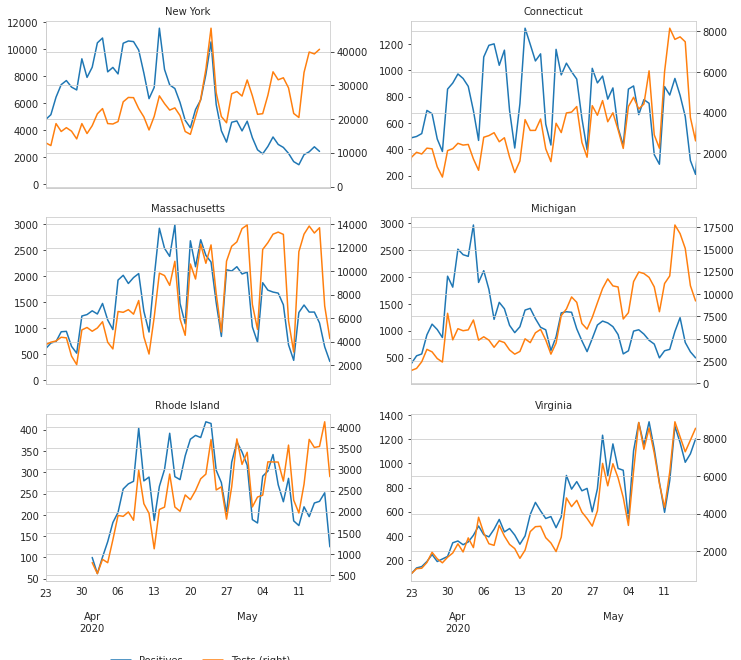

In [10]:
plt.close(1)

current_palette = sns.color_palette()

df = pd.concat(df_dict).reset_index()
df = df.rename(columns={'level_0': 'State'})
df['Tests (right)'] = df['Tests']
g = sns.FacetGrid(df, col='State', col_wrap=2, xlim=[df.Date.min(), df.Date.max()], sharey=False, aspect=1.3, dropna=False)

legend_and_hand = []
def myplot(data, y=None, secondary_y=None, legend=None, color=None):
    ax = data.plot(x='Date', y=y[0], ax=plt.gca(), label=y[0])
    legend_and_hand.append(ax.get_legend_handles_labels())
    ax = data.plot(x='Date', y=y[1], secondary_y=secondary_y, ax=ax, label=y[1])
    legend_and_hand.append(ax.get_legend_handles_labels())
    return ax
g.map_dataframe(myplot, y=['Positives', 'Tests (right)'], secondary_y=['Tests (right)'])

#g.axes[0].xaxis.set_major_locator(locator)
#g.axes[0].xaxis.set_major_formatter(formatter)

g.add_legend({l[0]: h[0] for h,l in legend_and_hand[:2]}, bbox_to_anchor=(0.4, 0), ncol=2) #, loc='lower center'
g.set_titles('{col_name}')
plt.tight_layout()
plt.savefig('figs/state_testes.jpg', dpi=300)

## Relationship between the total number of infected individuals and positive tests

As has been shown previously [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185), the number of new infected individuals in a given day $k_t$ is given by:
$$
k_t = k_{t-1} e^{(R_{t-1}-1)\gamma}
$$

where $R_t$ is the effective reproductuve number and $\gamma^{-1}$ is the infectious period estimated as 7 days accoring to [2].

The following derivation was suggested to my by Will Meierjurgen Farr on this GitHub [Issue](https://github.com/k-sys/covid-19/issues/45#issuecomment-623782130). 
Since we do not have access to the total number of infected indiviudals, but only to the population being tested, we have to use some statisticals assumtions on this populations.
If we asume that the people being tested, in a given day, is a sample of the population with COVID-19-like sympoms we can state that:

$$
n_{t} = [P_t(CV|sympoms) P_t(sympoms) +P_t(not CV|sympoms)P_t(sympoms)]Nf_t 
$$

where $n_{t}$ is the number of people tested, $P_t(CV|sympoms)$ is the probablity of a pacient being positive for coronavirus given that the she is sympomatic, $P_t(sympoms)$ is the probablity of having COVID-like sympoms, $P_t(not CV|sympoms)$ is the probability of a pacient being coronavirus negative given he has COVID-19-like sympoms, $N$ is the total population, and $f_t$ is the fraction of people with sympoms that is selected to be tested (this number can be different each day, for example if the number of tests availabes changes).
Also, note that the probability of a test being positive in a given day is $Positive_t=P_t(CV|sympoms) P_t(sympoms) N f_t$


Now, if we assume that $P_t(sympoms|CV)=cte$ we can use Bayes theorem to show that:

$$
P_t(CV|sympoms) P_t(sympoms) \propto P_t(CV) = \frac{k_t}{N}
$$

Then:
$$
P_t(CV|sympoms) P_t(sympoms) \propto k_t
$$

Finally, if we assume that $P_t(not CV|sympoms)P_t(sympoms)=cte$:
$$
Odds_t = \frac{P(CV|sympoms) P(sympoms)Nf_t}{P_t(not CV|sympoms)P_t(sympoms)Nf_t}
$$
$$
Odds_t = \frac{P(CV|sympoms) P(sympoms)}{P_t(not CV|sympoms)P_t(sympoms)}
$$
$$
Odds_t \propto k_t
$$

\begin{equation}
Odds_t = Odds_{t-1} e^{(R_{t-1}-1)\gamma} (1)
\end{equation}

We used three hypothesis. First, constant population $N$ (for $P_t \propto k_t$ and for the evolution of $k_t$). Second, that the tested population is a random sample from the population with COVID19-like sympoms ($n_t = [P_t(CV|sympoms) P_t(sympoms) +P_t(not CV|sympoms)P_t(sympoms)]Nf_t$) this is not the case when people is being tested based on contacts for example. And third, that $P_t(not CV|sympoms)P_t(sympoms)=cte$, this is equivalent to say that the number of people with covid-19-like sympoms but without the coronavirus (for example people with the flu) is constant, or at least it changes are negligible compared with the changes in the amount of sympomatic people with coronavirus.

## Linearization

Defining

$$
b_i =  e^{(R_{i-1}-1)\gamma} (2)
$$

We can write [1] as:

\begin{equation}
odd_i = b_{i-1} * odd_{i-1} (3)
\end{equation}

Now, instead of using $b_i$ as the parameters to estimate we decompose each $b$ as follows:

$$
b_i = \prod_{j=0}^{i} a_j (4)
$$

Now, the $a_j$ represent the rate of change of the variable $b_i$. Next, we replace the [4] in [3]
$$
odd_i = \prod_{j=0}^{i-1} a_j * odd_{i-1}
$$
$$
odd_i = \prod_{j=0}^{i-1} a_j * \prod_{j=0}^{i-2} a_j * odd_{i-2}
$$
$$
odd_i = \prod_{k=0}^{i-1}\prod_{j=0}^{k} a_j * odd_{0}
$$
$$
odd_i = \prod_{j=0}^{i-1} a_j^{i-j} * odd_{0}
$$

Now, we liniarize this result and we generalize it to the case where $i=0$ using the $max$ function:

$$
log(odd_i) = \sum_{j=0}^{max(i-1, 0)} (i-j)log(a_j)  +  log(odd_{0}) (5)
$$

We can write [5] as a linear problem with the following definitions:

$$
y = X \beta + \beta_0
$$

$$
y_i = log(odd_i)
$$

$$
X_{i,j} =  max(i-j, 0)
$$

$$
\beta_i =  log(a_i) (6)
$$

Now if we apply a LASSO regression we will find the solution that minimize the following cost function

$$
Err = \sum (y-\hat{y})^2 + \alpha |\beta|_1
$$

Hopefully, this solution will be sparse which means that most of the $\beta_i$ will be $0$, and hence $a_i=1$.
This is equivalent to say that the $b_i$ are almost constant except at the values whete $a_i \neq 1$.



[1] Bettencourt, L. M. A., & Ribeiro, R. M. (2008). Real time bayesian estimation of the epidemic potential of emerging infectious diseases. PLoS ONE, 3(5). https://doi.org/10.1371/journal.pone.0002185

[2] Sanche, S., Lin, Y. T., Xu, C., Romero-Severson, E., Hengartner, N., & Ke, R. (2020). High Contagiousness and Rapid Spread of Severe Acute Respiratory Syndrome Coronavirus 2. Emerging Infectious Diseases, 26(7). https://doi.org/10.3201/eid2607.200282



## Classes

This cell contains the main class: LassoICSelector. Its main method is fit_best_alpha. It works as follows:
```
For each alpha value:
    1. Fits a lasso regression to the data
    2. Selectes the first non zero variable from each chunck
    3. Fits a linear regression with the selected variables
    4. Excludes all non sifgificative (p-value>0.05) variables and fits a linear model again

The linear model with less AIC from step 4 is selected.
```



In [11]:
class FirstInChunkSelector(object):
    '''Selects first element from each non zero chunk.'''

    def __init__(self, clf):
        self.clf = clf
        self.coef = None
        self.mask = None

    def select_coef(self):
        n_features = len(self.clf.coef_)
        no_zero = np.zeros(n_features+1)
        no_zero[1:] = self.clf.coef_ != 0
        self.mask = np.diff(no_zero)>0
        self.mask[0] = True
        self.coef = self.clf.coef_[self.mask]
        return self.coef

    def transform(self, X):
        self.select_coef()
        return X[:, self.mask]

    def get_support(self):
        self.select_coef()
        return self.mask

    def get_number_of_features(self):
        self.select_coef()
        return sum(self.mask)


class LassoICSelector(object):
    """LASSO regression with FirstInChunk selector."""

    def __init__(self, X, y, criterion, alpha=0.05):
        self.lasso = linear_model.LassoLars(alpha=0, max_iter=100000)
        self.criterion = criterion
        self.selector = FirstInChunkSelector(self.lasso)
        self.OLS = sm.OLS
        self.ols = self.OLS(y, X)
        self.ols_results = None
        self.X = X
        self.y = y
        self.final_ols = False
        self.alpha = alpha

    def transform_to_ols(self, X):
        '''Selects only the features of X are used by OLS.
        Also, adds a coloumn with ones for the intercept.
        '''

        X_new = self.selector.transform(X)
        if self.final_ols:
            X_new = X[:, self.support]
        X_new_with_cte = np.hstack([X_new, np.ones((X_new.shape[0], 1))])
        return X_new_with_cte

    def fit(self, X, y):
        '''Selects features and fits the OLS.'''

        # select features
        X_new = self.transform_to_ols(X)

        # fit ols
        self.ols = self.OLS(y, X_new)
        self.ols_results = self.ols.fit()

        # iteratively remove non signicative variables and fit again
        mask = self.ols_results.pvalues < self.alpha / len(self.ols_results.pvalues)
        mask[0] = True
        Xnew = self.transform_to_ols(X)
        Xnew = Xnew[:, mask]
        self.support = self.selector.get_support()
        self.ols = self.OLS(y, Xnew)
        self.ols_results = self.ols.fit()
        while any(self.ols_results.pvalues[1:] >= self.alpha / len(self.ols_results.pvalues)):
            mask.values[mask.values] = (self.ols_results.pvalues < self.alpha / len(self.ols_results.pvalues)).values
            mask[0] = True
            Xnew = self.transform_to_ols(X)
            Xnew = Xnew[:, mask]
            self.support = self.selector.get_support()
            self.ols = self.OLS(y, Xnew)
            self.ols_results = self.ols.fit()

        self.support[self.support] = mask[:-1]

    def fit_best_alpha(self, X, y):
        '''returns the model with the lowst cirterion.'''

        self.lasso.fit(X, y)
        alphas = self.lasso.alphas_
        self.criterions_ = np.zeros(len(alphas))
        self.log_liklehods = np.zeros(len(alphas))
        
        
        for i, alpha in enumerate(alphas):
            self.lasso.coef_ = self.lasso.coef_path_[:, i]
            self.fit(X, y)
            self.criterions_[i], self.log_liklehods[i] = self.get_criterion(self.ols.exog, y)
        
        # we use a list of tuples to find the minimum cirterion value.
        # If there are ties, we use the maximum alpha value.
        criterions_idx = list(zip(self.criterions_, alphas, range(len(alphas))))
        criterion, alpha, idx = min(criterions_idx, key=lambda x: (x[0], -x[1]))
        #print(list(enumerate(zip(alphas, self.criterions_))))
        #print(alpha, criterion)
        self.lasso.coef_ = self.lasso.coef_path_[:, idx]
        self.lasso.alpha = alpha
        self.fit(X, y)
        self.final_ols = True

    def predict(self, X):
        '''Predicts y useing the OLS fit.'''

        return self.ols.predict(self.ols_results.params, X)

    def log_liklihood(self, X, y):
        '''Computes the log liklihood assuming normally distributed errors.'''

        eps64 = np.finfo('float64').eps

        # residuals
        R = y - self.predict(X)
        sigma2 = np.var(R)

        loglike = -0.5 * len(R) * np.log(sigma2)
        loglike -= 0.5 * len(R) * np.log(2*np.pi) - 0.5*len(R) + 0.5
        return loglike

    def get_criterion(self, X, y):
        '''Computes AIC or BIC criterion.'''

        n_samples = X.shape[0]
        if self.criterion == 'aic':
            K = 2  # AIC
        elif self.criterion == 'bic':
            K = np.log(n_samples)
        else:
            raise ValueError('criterion should be either bic or aic')

        log_like = self.log_liklihood(X, y)
        df = X.shape[1]

        aic = K * df - 2*log_like
        self.criterion_ = aic

        return self.criterion_, log_like

## Fit
Now, we create the linear system and fit the model

In [12]:
plt.close('all')
lics_dict = {}
#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
gof_list = []
for i, state in enumerate(df.State.unique()):
    dfstate = df[df['State']==state]
    # create the independent and the dependent variables
    y = np.log(dfstate['Odds'])
    X = np.tri(len(y))
    X = np.cumsum(X, axis=0)[:, 1:]
    X = X[dfstate.Odds.notna(), :]
    y = y[dfstate.Odds.notna()]

    # create lasso instance
    lics = LassoICSelector(X, y.values, 'bic')

    # fit
    lics.fit_best_alpha(X, y)
    lics_dict[state] = lics

    #     ax = sns.lineplot(lics.lasso.alphas_, lics.criterions_, ax=axes[2, i])
    #     ax.vlines(lics.lasso.alpha, min(lics.criterions_), max(lics.criterions_))
    #     ax.set_ylabel('BIC')
    #     ax.set_xlabel('Alpha')
    #     ax.set_xscale('log')
    #     axes[0, i].plot(lics.lasso.alphas_, lics.lasso.coef_path_.T)
    #     axes[0, i].set_xscale('log')
    #     axes[0, i].set_title(state)
    #     axes[0, i].set_xlabel('Alpha')
    #     axes[0, i].set_ylabel('Coefficient Value')
    #     axes[0, i].vlines(lics.lasso.alpha, lics.lasso.coef_path_.min(), lics.lasso.coef_path_.max())
    #     axes[1, i].plot(lics.lasso.coef_)
    #     axes[1, i].scatter(np.arange(len(lics.lasso.coef_))[lics.support], lics.lasso.coef_[lics.support])
    #     axes[1, i].set_xlabel('Coefficient #')
    #     axes[1, i].set_ylabel('Coefficient Value')
    #     print(state)
    #     print('{} & {} & {} & {} & {} & {}'.format(state, lics.ols_results.rsquared, lics.ols_results.nobs, lics.ols_results.df_model, lics.ols_results.fvalue, lics.ols_results.f_pvalue))
    #     display(lics.ols_results.summary())
    gof_list.append({"State":state, '$R^2$':lics.ols_results.rsquared, "N": int(lics.ols_results.nobs), "df_model": int(lics.ols_results.df_model), "fvalue":lics.ols_results.fvalue, "f_pvalue":lics.ols_results.f_pvalue})
# plt.tight_layout(pad=0.0)
# plt.savefig('figs/framework.jpg', dpi=300)
# plt.show()
gof = pd.DataFrame(gof_list).sort_values('$R^2$', ascending=False)
out = gof.to_latex(index=False,formatters={"$R^2$": "{:0.3f}".format, 'fvalue':"{:0.3f}".format, 'f_pvalue': "{:.2e}".format},
             bold_rows=True, escape=False)
print(out)

\begin{tabular}{lrrrrr}
\toprule
         State & $R^2$ &   N &  df_model &   fvalue & f_pvalue \\
\midrule
      New York & 0.989 &  62 &         4 & 1251.214 & 8.60e-55 \\
 Massachusetts & 0.982 &  64 &         3 & 1072.881 & 4.64e-52 \\
      Michigan & 0.971 &  62 &         3 &  639.142 & 2.23e-44 \\
   Connecticut & 0.951 &  61 &         3 &  365.902 & 3.44e-37 \\
  Rhode Island & 0.838 &  47 &         2 &  113.879 & 4.02e-18 \\
      Virginia & 0.741 &  56 &         2 &   75.841 & 2.82e-16 \\
\bottomrule
\end{tabular}



Lets copy the fitted values to a dataframe, and calculate the parameters and erros of the model.

In [13]:
data_list = []
Rt_dict = {}
for state in df.State.unique():
    print(state)
    lics = lics_dict[state]
    data = df[df['State']==state].copy()

    # yhat = lics.ols_results.fittedvalues
    y = np.log(data['Odds'])
    X = np.tri(len(y))
    X = np.cumsum(X, axis=0)[:, 1:]
    Xols = lics.transform_to_ols(X)
    yhat = lics.ols.predict(lics.ols_results.params, Xols)
    # from equation 5
    odds_hat = np.exp(yhat)

    # the error in yhat is
    # Xols = lics.transform_to_ols(X)
    (yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, Xols)
    oddshat_l = np.exp(yhat-2*yhat_std)
    oddshat_u = np.exp(yhat+2*yhat_std)

    data.loc[:, 'odds_hat'] = odds_hat
    data.loc[:, 'oddshat_l'] = oddshat_l
    data.loc[:, 'oddshat_u'] = oddshat_u

    # use coefficients to calculate Rt
    coef = np.zeros(len(data))
    coef_std = np.zeros_like(coef) * np.nan
    ind = np.squeeze(np.argwhere(lics.support))

    # we do not use the last coefficient since it's the intercept (=log(odds_0))
    coef[ind] = lics.ols_results.params[:-1]

    # using equation 2, 4 and 6
    data.loc[:, 'R'] = np.cumsum(coef)/GAMMA+1

    # get covarinace matrix of coefficients
    cov = lics.ols_results.cov_params().values

    # since the values of Rts are a sum of variables, we use the formula
    # of the sum of gaussian variables with a known covariance matrix
    stds = [np.sqrt(cov[:n, :n].sum()) for n in range(1, cov.shape[0])]
    if len(stds)==1:
        stds = stds[0]
    coef_std[ind] = stds

    # error propagation formula
    data.loc[:, 'Rstd'] = coef_std / GAMMA

    data['Rstd'] = data['Rstd'].fillna(method='ffill')
    data['R_l'] = data['R'] - 2*data['Rstd']
    data['R_u'] = data['R'] + 2*data['Rstd']

    r_index = data.R.diff() != 0
    Rts = data.loc[r_index, ['Date', 'R', 'R_l', 'R_u']]
    Rts['delta'] = Rts['R_u'] - Rts['R_l']
    Rt_dict[state] = Rts
    display(Rts)
    #print(np.cumsum(coef)[r_index], coef_std[r_index])
    data_list.append(data)
data = pd.concat(data_list)
Rts = pd.concat(Rt_dict, names=['Dataset'])

New York


,Date,R,R_l,R_u,delta
0,2020-03-15,2.097828,1.943739,2.251917,0.308179
8,2020-03-23,1.567515,1.431863,1.703166,0.271303
15,2020-03-30,0.726109,0.675574,0.776644,0.101070
30,2020-04-14,0.439509,0.415892,0.463126,0.047234


Connecticut


,Date,R,R_l,R_u,delta
62,2020-03-20,1.779764,1.596979,1.962549,0.365570
71,2020-03-29,0.981041,0.905938,1.056145,0.150207
86,2020-04-13,0.601700,0.571878,0.631522,0.059644


Massachusetts


,Date,R,R_l,R_u,delta
123,2020-03-15,1.872406,1.814039,1.930773,0.116734
136,2020-03-28,1.158793,1.122085,1.195501,0.073416
151,2020-04-12,0.659066,0.643282,0.674850,0.031568


Michigan


,Date,R,R_l,R_u,delta
187,2020-03-17,1.464358,1.393495,1.535221,0.141726
205,2020-04-04,0.415219,0.368090,0.462348,0.094258
227,2020-04-26,0.670931,0.612907,0.728954,0.116047


Rhode Island


,Date,R,R_l,R_u,delta
249,2020-04-01,1.070697,1.005958,1.135437,0.129479
268,2020-04-20,0.714994,0.672172,0.757816,0.085644


Virginia


,Date,R,R_l,R_u,delta
296,2020-03-23,1.130957,1.108889,1.153025,0.044135
323,2020-04-19,0.896946,0.875805,0.918088,0.042283


In [14]:
Rts = pd.concat(Rt_dict, names=['Dataset'])
Rts = Rts.reset_index().drop('level_1', axis=1)#[['Dataset', 'Date', 'R', #.rename(columns={'level_'})
'('+Rts.R_l.round(2).astype(str)

Rts['figures'] = (-np.floor(np.log10(Rts.delta))+1).astype(int)
Rts['R'] = Rts.apply(lambda row: np.round(row['R'], row['figures']), axis=1)
Rts['R'] = Rts.apply(lambda row: '{:0.{}f}'.format(row['R'], row['figures']), axis=1)
Rts['R_l'] = Rts.apply(lambda row: np.round(row['R_l'], row['figures']), axis=1)
Rts['R_u'] = Rts.apply(lambda row: np.round(row['R_u'], row['figures']), axis=1)
Rts['95 % C.I.'] = Rts.apply(lambda row: '({}, {})'.format(row['R_l'], row['R_u']), axis=1)
print(Rts[['Dataset', 'Date', 'R', '95 % C.I.']].to_latex(caption='Values of $R_t$ for each dataset and times of $R_t$ change.',
                                                         label='tab:rt', index=False))

\begin{table}
\centering
\caption{Values of $R_t$ for each dataset and times of $R_t$ change.}
\label{tab:rt}
\begin{tabular}{llll}
\toprule
       Dataset &       Date &      R &       95 \% C.I. \\
\midrule
      New York & 2020-03-15 &   2.10 &    (1.94, 2.25) \\
      New York & 2020-03-23 &   1.57 &     (1.43, 1.7) \\
      New York & 2020-03-30 &   0.73 &    (0.68, 0.78) \\
      New York & 2020-04-14 &  0.440 &  (0.416, 0.463) \\
   Connecticut & 2020-03-20 &   1.78 &     (1.6, 1.96) \\
   Connecticut & 2020-03-29 &   0.98 &    (0.91, 1.06) \\
   Connecticut & 2020-04-13 &  0.602 &  (0.572, 0.632) \\
 Massachusetts & 2020-03-15 &   1.87 &    (1.81, 1.93) \\
 Massachusetts & 2020-03-28 &  1.159 &  (1.122, 1.196) \\
 Massachusetts & 2020-04-12 &  0.659 &  (0.643, 0.675) \\
      Michigan & 2020-03-17 &   1.46 &    (1.39, 1.54) \\
      Michigan & 2020-04-04 &  0.415 &  (0.368, 0.462) \\
      Michigan & 2020-04-26 &   0.67 &    (0.61, 0.73) \\
  Rhode Island & 2020-04-01 &   1.07 

In [15]:
Rtsdiff = Rts.copy()
Rtsdiff = Rtsdiff.drop(1)
Rtsdiff = Rtsdiff[Rtsdiff.index<10]
Rtsdiff['R2'] = Rtsdiff['R'].astype(float)
Rtsdiff['R1'] = Rtsdiff.groupby('Dataset')['R2'].shift(1)
Rtsdiff['Rd'] = 1-Rtsdiff['R2']/Rtsdiff['R1']

Rtsdiff['Delta_R1'] = Rtsdiff.groupby('Dataset')['delta'].shift(1)
Rtsdiff['Delta_R2'] = Rtsdiff['delta']
Rtsdiff['Delta_Rd'] = Rtsdiff['Delta_R1']*Rtsdiff['R2']/Rtsdiff['R1']**2 + Rtsdiff['Delta_R2']/Rtsdiff['R1']
Rtsdiff = Rtsdiff.dropna()
Rtsdiff['Rd_l'] = Rtsdiff['Rd'] - Rtsdiff['Delta_Rd']/2
Rtsdiff['Rd_u'] = Rtsdiff['Rd'] + Rtsdiff['Delta_Rd']/2

Rtsdiff['Rd'] = Rtsdiff['Rd']*100
Rtsdiff['Rd_l'] = Rtsdiff['Rd_l']*100
Rtsdiff['Rd_u'] = Rtsdiff['Rd_u']*100
Rtsdiff['figures'] = (-np.floor(np.log10(100*Rtsdiff.Delta_Rd))+1).astype(int)
Rtsdiff['Rd'] = Rtsdiff.apply(lambda row: np.round(row['Rd'], row['figures']), axis=1)
Rtsdiff['Rd'] = Rtsdiff.apply(lambda row: '{:0.{}f}'.format(row['Rd'], row['figures']), axis=1)
Rtsdiff['Rd_l'] = Rtsdiff.apply(lambda row: np.round(row['Rd_l'], row['figures']), axis=1)
Rtsdiff['Rd_u'] = Rtsdiff.apply(lambda row: np.round(row['Rd_u'], row['figures']), axis=1)
Rtsdiff['95 \% C.I.'] = Rtsdiff.apply(lambda row: '({}, {})'.format(row['Rd_l'], row['Rd_u']), axis=1)

Rtsdiff = Rtsdiff.reset_index()
Rtsdiff['Intervention'] = ['Mobility restrictions', 'Masks',
                           'Mobility restrictions', 'Masks',
                           'Mobility restrictions', 'Masks']
#Rtsdiff[['Dataset', 'Rd','95 % C.I.', 'Intervention']]
Rtsdiff['$R_t$ \% reduction'] = Rtsdiff['Rd']
Rtsdiff = Rtsdiff[['Dataset', 'Intervention', '$R_t$ \% reduction', '95 \% C.I.']]
print(Rtsdiff.to_latex(caption='Changes in $R_t$ due to each type of NPIs.',
                       label='tab:rt_reduction', index=False, escape=False))

\begin{table}
\centering
\caption{Changes in $R_t$ due to each type of NPIs.}
\label{tab:rt_reduction}
\begin{tabular}{llll}
\toprule
       Dataset &           Intervention & $R_t$ \% reduction &    95 \% C.I. \\
\midrule
      New York &  Mobility restrictions &               65.2 &  (60.3, 70.2) \\
      New York &                  Masks &                 40 &  (32.0, 47.0) \\
   Connecticut &  Mobility restrictions &                 45 &  (35.0, 55.0) \\
   Connecticut &                  Masks &                 39 &  (31.0, 46.0) \\
 Massachusetts &  Mobility restrictions &               38.0 &  (34.1, 41.9) \\
 Massachusetts &                  Masks &               43.1 &  (40.0, 46.3) \\
\bottomrule
\end{tabular}
\end{table}



In [16]:
state = 'New York'
params_stats_list = []
for state in lics_dict:
    res = lics_dict[state].ols_results
    dir(res)
    params_stats = res.params
    params_stats = pd.DataFrame({'Coef. Name': res.params.index,
                                 'Coefficient':res.params, 
                                 'Std': pd.Series(np.diag(res.cov_params())**0.5, index=res.cov_params().index),
                                  'p-value': res.pvalues},
                                index=res.params.index)
    params_stats['c_l'] = params_stats['Coefficient']-2*params_stats['Std']
    params_stats['c_u'] = params_stats['Coefficient']+2*params_stats['Std']
    params_stats['delta'] = 4*params_stats['Std']
    params_stats['figures'] = (-np.floor(np.log10(params_stats.delta))+1).astype(int)
    params_stats['c_u'] = params_stats.apply(lambda row: np.round(row['c_u'], row['figures']), axis=1)
    params_stats['c_l'] = params_stats.apply(lambda row: np.round(row['c_l'], row['figures']), axis=1)
    params_stats['Coefficient'] = params_stats.apply(lambda row: np.round(row['Coefficient'], row['figures']), axis=1)
    params_stats['Coefficient'] = params_stats.apply(lambda row: '${:0.{}f}$'.format(row['Coefficient'], row['figures']), axis=1)
    params_stats['c_u'] = params_stats.apply(lambda row: '{:0.{}f}'.format(row['c_u'], row['figures']), axis=1)
    params_stats['c_l'] = params_stats.apply(lambda row: '{:0.{}f}'.format(row['c_l'], row['figures']), axis=1)
    params_stats['95\% C.I.'] = params_stats.apply(lambda row: '$({}, {})$'.format(row['c_l'], row['c_u']), axis=1)
    params_stats['Dataset'] = state
    params_stats_list.append(params_stats)

params_stats = pd.concat(params_stats_list)[['Dataset', 'Coef. Name', 'Coefficient', '95\% C.I.', 'p-value']]
params_stats_latex = params_stats.to_latex(index=False,
                                           label='tab:coef',
                                           caption='Parameter values and statistics for the selected model for each dataset',
                                           escape=False,
                                           formatters={'p-value': "{:.2e}".format})
print(params_stats_latex)

\begin{table}
\centering
\caption{Parameter values and statistics for the selected model for each dataset}
\label{tab:coef}
\begin{tabular}{llllr}
\toprule
       Dataset & Coef. Name & Coefficient &           95\% C.I. &  p-value \\
\midrule
      New York &         x1 &     $0.146$ &    $(0.126, 0.167)$ & 1.94e-20 \\
      New York &         x2 &    $-0.071$ &  $(-0.106, -0.036)$ & 1.60e-04 \\
      New York &         x3 &    $-0.112$ &  $(-0.135, -0.089)$ & 7.51e-14 \\
      New York &         x4 &    $-0.038$ &  $(-0.047, -0.029)$ & 8.96e-12 \\
      New York &      const &     $-1.70$ &    $(-1.81, -1.59)$ & 4.50e-37 \\
   Connecticut &         x1 &     $0.104$ &    $(0.080, 0.128)$ & 9.05e-12 \\
   Connecticut &         x2 &    $-0.106$ &  $(-0.138, -0.075)$ & 7.91e-09 \\
   Connecticut &         x3 &    $-0.051$ &  $(-0.063, -0.038)$ & 8.56e-11 \\
   Connecticut &      const &     $-1.35$ &    $(-1.51, -1.19)$ & 9.49e-24 \\
 Massachusetts &         x1 &     $0.116$ &    $(0.109,

Now, we plot the Rt as function of time and the fitted values.

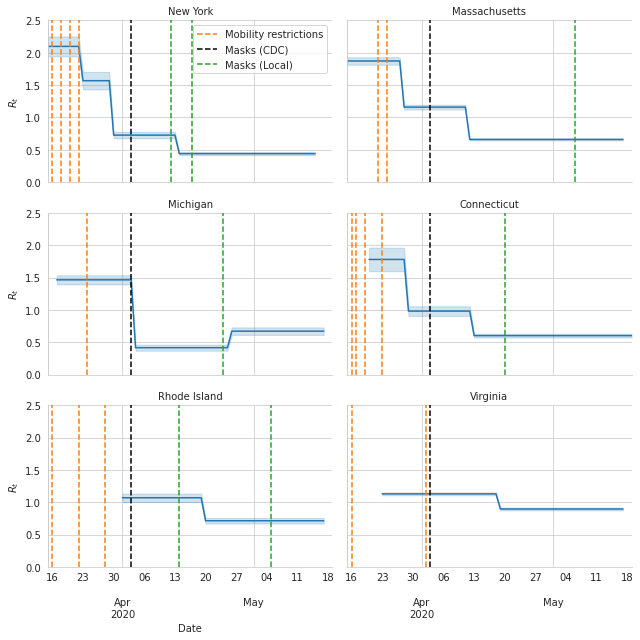

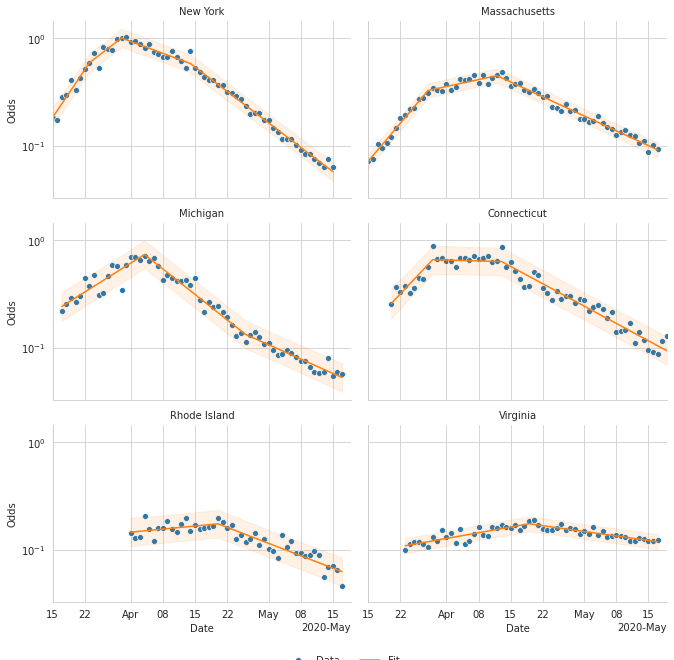

In [17]:
plt.close('all')

g1 = sns.FacetGrid(data.set_index('date'), col='State', col_wrap=2, ylim=[0, 2.5], aspect=1.5, dropna=False, col_order=gof.State)
def myplot(data, y=None, color=None):
    data.plot(x='Date', y=y, ax=plt.gca())
#g1.map_dataframe(sns.lineplot, x='Date', y='R')
g1.map_dataframe(myplot, y='R')
g1.map(plt.fill_between, 'Date', 'R_u', 'R_l', alpha=0.2)
#ax = data.plot(x='Date', y='R', legend=False)
lines = []
for ax, dsname in zip(g1.axes, gof.State):
    if dsname in events:
        for line in events[dsname]:
            if line < pd.to_datetime('03-04-2020 00:00', dayfirst=True):
                color = current_palette[1]
                label = 'Mobility restrictions'
            elif line == pd.to_datetime('03-04-2020 00:00', dayfirst=True):
                color = 'k'
                label = 'Masks (CDC)'
            else:
                label = 'Masks (State)'
                color = current_palette[2]
            lines.append(ax.axvline(line, 0,1, linestyle='--', color=color, label=label))

#     lines_mr = [line for line in events[dsname] if line<pd.to_datetime('03-04-2020 00:00', dayfirst=True)]
#     lines_masks = [line for line in events[dsname] if line>pd.to_datetime('03-04-2020 00:00', dayfirst=True)]
#     ax.axvlines(lines_mr, 0,1, linestyle='--', color='r', label='Movility restrictions')
#     ax.axvline(pd.to_datetime('03-04-2020 00:00', dayfirst=True), 0,1, linestyle='--', color='r', label='Masks (CDC)')
#     ax.axvlines(lines_masks, 0,1, linestyle='--', color='r', label='Masks (Local)')

g1.set(ylabel='$R_t$')
#from pandas.plotting._matplotlib.timeseries import format_dateaxis
#format_dateaxis(g1.axes[0,0], 1, data.index)
#g1.axes[0,0].xaxis.set_major_locator(locator)
#g1.axes[0,0].xaxis.set_major_formatter(formatter)
g1.set(yscale='linear')
g1.axes[0].legend([lines[0], lines[4], lines[5]], ['Mobility restrictions', 'Masks (CDC)', 'Masks (Local)'])
#print(g1.axes[0, 0].legend().get_legend_handler_map())
plt.xlabel('')

g1.set(xlim=[data.date.min(), data.date.max()])
g1.set_titles('{col_name}')
plt.tight_layout()
plt.savefig('figs/states6_RtL1.jpg', dpi=300)




stacked = data.set_index(['Date', 'State'])[['Odds', 'odds_hat', 'oddshat_u', 'oddshat_l']]
stacked = stacked.stack().reset_index().rename(columns={'level_2': 'variable', 0: 'val'})
stacked['Branch'] = 'Fit'
stacked.loc[stacked['variable'] == 'Odds', 'Branch'] = 'Data'
stacked = stacked.set_index(['Date', 'State', 'Branch', 'variable']).unstack().reset_index()
stacked.columns = ['Date', 'State', 'Branch', 'Odds', 'odds_hat', 'oddshat_u', 'oddshat_l']
stacked = stacked.sort_values(['State', 'Date'])

g = sns.FacetGrid(stacked, col='State', col_wrap=2, hue='Branch', aspect=1.3, dropna=False, hue_order=['Data', 'Fit'], col_order=gof.State)
g.map_dataframe(sns.lineplot, x='Date', y='odds_hat')
g.map_dataframe(sns.scatterplot, x='Date', y='Odds')
g.map(plt.fill_between, 'Date', 'oddshat_l', 'oddshat_u', alpha=0.1)
#.set_yscale('log')
g.set(yscale='log')

hl = g.axes[0].get_legend_handles_labels()

handlers = [hl[0][1], hl[0][0]]
labels = [hl[1][1], hl[1][0]]

lh = {l:h for h,l in zip(handlers, labels)}
# plt.ylabel('Odds')
g.set(xlim = (data['Date'].min(), data['Date'].max()))
g.set_titles('{col_name}')
g.set(yscale='log')
g.axes[0].xaxis.set_major_locator(locator)
g.axes[0].xaxis.set_major_formatter(formatter)
g.add_legend(lh, bbox_to_anchor=(0.6, 0), title='', ncol=3)#, loc='lower center'

g.set(ylabel='Odds')
plt.tight_layout()
plt.savefig('figs/states6_OddsL1.jpg', dpi=300)

## Counterfactual

In [18]:
# for state in df.State.unique():
#     print(state)
#     lics = lics_dict[state]
#     #data = df[df['State']==state].copy()

#     # yhat = lics.ols_results.fittedvalues
#     y = np.log(data.loc[data['State']==state, 'Odds'])
#     X = np.tri(len(y))
#     X = np.cumsum(X, axis=0)[:, 1:]
#     fitted_params = lics.ols_results.params.copy()
#     current_palette = sns.color_palette()


#     params_cf = lics.ols_results.params.copy()
#     params_cf[-2] = 0
#     lics.ols_results.params = params_cf
#     #exog = np.hstack([lics.transform_to_ols(X)[:,:-2], lics.transform_to_ols(X)[:,-1:]])
#     yhat = lics.predict(lics.transform_to_ols(X))
#     odds_cf = np.exp(yhat)
#     (yhat_std, yhat_l, yhat_u) = wls_prediction_std(lics.ols_results, lics.transform_to_ols(X))
#     oddshat_std = odds_cf*yhat_std

#     lics.ols_results.params = fitted_params
#     ratio_cf = odds_cf / (odds_cf+1)

#     coef = np.zeros(len(data.loc[data['State']==state]))
#     ind = np.squeeze(np.argwhere(lics.support))
#     coef[ind] = params_cf[:-1]
#     data.loc[data['State']==state, 'R_cf'] = np.cumsum(coef)/GAMMA+1

#     data.loc[data['State']==state, 'Odds CF'] = odds_cf
#     data.loc[data['State']==state, 'Odds CF std'] = oddshat_std
#     data.loc[data['State']==state, 'oddshat_l_cf'] = odds_cf - 2*oddshat_std
#     data.loc[data['State']==state, 'oddshat_u_cf'] = odds_cf + 2*oddshat_std

#     data.loc[data['State']==state, 'ratio_cf'] = ratio_cf
#     break
    
# #     plt.figure()
# #     ax = sns.scatterplot(x='Date', y='Odds', data=data[data['State']==state], label='Data', c=np.array([current_palette[0]]))

# #     ax = sns.lineplot(x='Date', y='odds_hat', data=data[data['State']==state], ax=ax, palette=[current_palette[i]], label='Fit')
# #     ax.fill_between(data.loc[data['State']==state, 'Date'], data.loc[data['State']==state, 'oddshat_l'],
# #                     data.loc[data['State']==state, 'oddshat_u'],
# #                     alpha=0.1)

# #     ax = sns.lineplot(x='Date', y='Odds CF', data=data[data['State']==state], ax=ax, label='Counterfactual No Masks')#, palette=[current_palette[i]]
# #     ax.fill_between(data.loc[data['State']==state, 'Date'], data.loc[data['State']==state, 'oddshat_l_cf'],
# #                     data.loc[data['State']==state, 'oddshat_u_cf'],
# #                     alpha=0.1)

# #     plt.yscale('log')

# #     ax.xaxis.set_major_locator(locator)
# #     ax.xaxis.set_major_formatter(formatter)
# #     plt.grid(True)
# #     plt.ylabel('Odds')
# #     ax.set_xlim(data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max())
# #     plt.tight_layout()
# #     plt.savefig('figs/odds_cf_masks.jpg', dpi=300)
# #     plt.show()

In [19]:
for state in df.State.unique():
    print(state)
    lics = lics_dict[state]

    y = np.log(data.loc[data['State']==state, 'Odds'])
    X = np.tri(len(y))
    X = np.cumsum(X, axis=0)[:, 1:]
    exog_full = lics.transform_to_ols(X)
    ind = exog_full[:, -2]<2
    y_sub = y[ind]
    exog_sub = exog_full[ind,:]
    exog_sub = np.hstack([exog_sub[:, :-2],exog_sub[:,-1:]])
    ols = sm.OLS(y_sub, exog_sub)
    res = ols.fit()
    exog = np.hstack([exog_full[:, :-2],exog_full[:,-1:]])
    yhat = res.predict(exog)
    yhat_orig = lics.predict(exog_full)

    odds_cf = np.exp(yhat)
    (yhat_std, yhat_l, yhat_u) = wls_prediction_std(res, exog)
    oddshat_std = odds_cf*yhat_std

    #lics.ols_results.params = fitted_params
    ratio_cf = odds_cf / (odds_cf+1)

    #ind = np.squeeze(np.argwhere(lics.support))

    data.loc[data['State']==state, 'Odds CF'] = odds_cf
    data.loc[data['State']==state, 'Odds CF std'] = oddshat_std
    data.loc[data['State']==state, 'oddshat_l_cf'] = odds_cf - 2*oddshat_std
    data.loc[data['State']==state, 'oddshat_u_cf'] = odds_cf + 2*oddshat_std

    data.loc[data['State']==state, 'ratio_cf'] = ratio_cf

New York
Connecticut
Massachusetts
Michigan
Rhode Island
Virginia


In [20]:
# plt.close('all')
# g1 = sns.FacetGrid(data, row='State', aspect=1.5)
# g1.map_dataframe(sns.scatterplot, x='Date', y='Odds', label='Data')
# g1.map_dataframe(sns.lineplot, x='Date', y='odds_hat', label='Fit')
# def myfill_between(*args, **kwargs):
#     ax = plt.gca()
#     ax.fill_between(*args, **kwargs)
# g1.map(myfill_between, 'Date', 'oddshat_l', 'oddshat_u', alpha=0.1)

# g1.map_dataframe(sns.lineplot, x='Date', y='Odds CF', label='Counterfactual No Masks', palette=[current_palette[2]])
# g1.map(plt.fill_between, 'Date', 'oddshat_l_cf', 'oddshat_u_cf', alpha=0.1)

# plt.yscale('log')

# #ax.xaxis.set_major_locator(locator)
# #ax.xaxis.set_major_formatter(formatter)
# #plt.grid(True)
# #plt.ylabel('Odds')
# g1.set(xlim=[data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max()])
# #plt.tight_layout()
# #plt.savefig('figs/odds_cf_masks.jpg', dpi=300)
# plt.show()

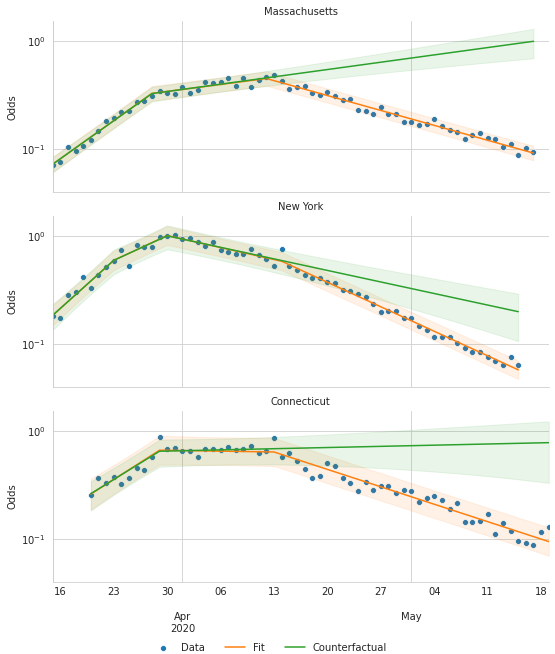

In [21]:
pepe = data.set_index(['Date', 'State', ])[['Odds', 'odds_hat', 'oddshat_u', 'oddshat_l', 'Odds CF', 'oddshat_u_cf', 'oddshat_l_cf']]
pepe = pepe.stack().reset_index().rename(columns={'level_2': 'variable', 0: 'val'})
pepe['Branch'] = 'Fit'
pepe.loc[pepe['variable'].str.lower().str.contains('cf'), 'Branch'] = 'Counterfactual'
pepe.loc[pepe['variable'] == 'Odds', 'Branch'] = 'Data'
pepe.loc[pepe['variable']=='Odds CF', 'variable'] = 'odds_hat'
pepe.loc[pepe['variable']=='oddshat_u_cf', 'variable'] = 'oddshat_u'
pepe.loc[pepe['variable']=='oddshat_l_cf', 'variable'] = 'oddshat_l'
pepe = pepe.set_index(['Date', 'State', 'Branch', 'variable']).unstack().reset_index()
pepe.columns = ['Date', 'State', 'Branch', 'Odds', 'odds_hat', 'oddshat_u', 'oddshat_l']

pepe = pepe[pepe['State'].isin(['New York', 'Connecticut', 'Massachusetts'])]
plt.close('all')




g1 = sns.FacetGrid(pepe, row='State', hue='Branch', aspect=1.5, dropna=False, hue_order=['Data', 'Fit', 'Counterfactual'])
legend_and_hand = []
def myplot(data, x=None, y=None, color=None, label=None):
    ax = plt.gca()
    ax = data.plot(x=x, y=y, ax=ax, label=label)
    legend_and_hand.append(ax.get_legend_handles_labels())
    return ax
g1.map_dataframe(myplot, x='Date', y='odds_hat')
g1.map_dataframe(sns.scatterplot, x='Date', y='Odds')


g1.map(plt.fill_between, 'Date', 'oddshat_l', 'oddshat_u', alpha=0.1)
hl = g1.axes[0,0].get_legend_handles_labels()

lh = {l:h for h,l in zip(hl[0][1:4], hl[1][1:4])}

g1.add_legend(lh, bbox_to_anchor=(0.7, 0.01), title='', ncol=3)#, loc='lower center'

plt.yscale('log')
plt.xlabel('')

g1.set(xlim=[data['Date'].min(), data.loc[data.odds_hat.notna(), 'Date'].max()], ylabel='Odds')
g1.set_titles("{row_name}")
plt.tight_layout(h_pad=1)
plt.savefig('figs/odds_cf_masks.jpg', dpi=300)
plt.show()

In [22]:
for state in  ['New York', 'Connecticut', 'Massachusetts']:
    subdata = data[data['State']==state]
    Positives_CF = subdata['Tests'] * subdata['Odds CF']/(subdata['Odds CF']+1)
    Positives_CF_std = subdata['Odds CF std'] * subdata['Tests'] /(subdata['Odds CF']+1)**2
    Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
    Positive_diff = (Positives_CF - subdata['Positives']).sum()
    Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
    Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
    Positives_fit = subdata['Tests'] * subdata['odds_hat']/(subdata['odds_hat']+1)
    print('{} & Counterfactual cases diff {} & CI ({} {})'.format(state, Positive_diff, Positive_diff_l, Positive_diff_u))
    #print('{} & Counterfactual death diff {} CI ({} {})'.format(0.077*Positive_diff, 0.077*Positive_diff_l, 0.077*Positive_diff_u))

Positives_CF = data['Tests'] * data['Odds CF']/(data['Odds CF']+1)
Positives_CF_std = data['Odds CF std'] * data['Tests'] /(data['Odds CF']+1)**2
Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
Positive_diff = (Positives_CF - data['Positives']).sum()
Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
Positives_fit = data['Tests'] * data['odds_hat']/(data['odds_hat']+1)
print('All & Counterfactual cases diff {} &  CI ({} {})'.format(Positive_diff, Positive_diff_l, Positive_diff_u))
print('Counterfactual death diff {} CI ({} {})'.format(0.077*Positive_diff, 0.077*Positive_diff_l, 0.077*Positive_diff_u))

New York & Counterfactual cases diff 76939.6040468762 & CI (65252.762298588874 88626.44579516351)
Connecticut & Counterfactual cases diff 36354.90071094035 & CI (33124.178817701126 39585.62260417957)
Massachusetts & Counterfactual cases diff 83143.63343675967 & CI (79567.02602730246 86720.24084621688)
All & Counterfactual cases diff 200736.92764519624 &  CI (187810.77529641215 213663.07999398033)
Counterfactual death diff 15456.74342868011 CI (14461.429697823734 16452.057159536485)


In [23]:
max_date = min(data.loc[data['State']=='New York', 'Date'].max(), data.loc[data['State']=='Connecticut', 'Date'].max(), data.loc[data['State']=='Massachusetts', 'Date'].max())
min_date = pd.to_datetime('2020-04-14')
for state in  ['New York', 'Connecticut', 'Massachusetts']:
    subdata = data.loc[(data['State']==state) & (data['Date']<=max_date) & (data['Date']>=min_date)]
    Positives_CF = subdata['Tests'] * subdata['Odds CF']/(subdata['Odds CF']+1)
    Positives_CF_std = subdata['Odds CF std'] * subdata['Tests'] /(subdata['Odds CF']+1)**2
    Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
    Positive_diff = (Positives_CF - subdata['Positives']).sum()
    Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
    Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
    Positives_fit = subdata['Tests'] * subdata['odds_hat']/(subdata['odds_hat']+1)
    print('{} & Counterfactual cases diff {} & CI ({} {})'.format(state, Positive_diff, Positive_diff_l, Positive_diff_u))

ind = (data['Date']<=max_date) & (data['Date']>=min_date)
Positives_CF = data.loc[ind, 'Tests'] * data.loc[ind, 'Odds CF']/(data.loc[ind, 'Odds CF']+1)
Positives_CF_std = data.loc[ind, 'Odds CF std'] * data.loc[ind, 'Tests'] /(data.loc[ind, 'Odds CF']+1)**2
Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
Positive_diff = (Positives_CF - data.loc[ind, 'Positives']).sum()
Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
Positives_fit = data.loc[ind, 'Tests'] * data.loc[ind, 'odds_hat']/(data.loc[ind, 'odds_hat']+1)
print('All & Counterfactual cases diff {} &  CI ({} {})'.format(Positive_diff, Positive_diff_l, Positive_diff_u))
print('Counterfactual death diff {} CI ({} {})'.format(0.077*Positive_diff, 0.077*Positive_diff_l, 0.077*Positive_diff_u))
print('Analyzed span: {}'.format(max_date-min_date))

New York & Counterfactual cases diff 75648.39608260806 & CI (65411.52499152025 85885.26717369586)
Connecticut & Counterfactual cases diff 29589.231191984003 & CI (26802.681613687222 32375.780770280784)
Massachusetts & Counterfactual cases diff 78483.35049817203 & CI (75033.5430372708 81933.15795907326)
All & Counterfactual cases diff 187234.8756166341 &  CI (175898.072709131 198571.67852413718)
Counterfactual death diff 14417.085422480824 CI (13544.151598603086 15290.019246358563)
Analyzed span: 31 days 00:00:00


In [24]:
max_date = min(data.loc[data['State']=='New York', 'Date'].max(), data.loc[data['State']=='Connecticut', 'Date'].max(), data.loc[data['State']=='Massachusetts', 'Date'].max())
min_date = pd.to_datetime('2020-04-14')
for state in  ['New York', 'Connecticut', 'Massachusetts']:
    subdata = data.loc[(data['State']==state) & (data['Date']<=max_date) & (data['Date']>=min_date)]
    Positives_CF = subdata['Tests'] * subdata['Odds CF']/(subdata['Odds CF']+1)
    Positives_CF_std = subdata['Odds CF std'] * subdata['Tests'] /(subdata['Odds CF']+1)**2
    Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
    Positive_diff = (Positives_CF - subdata['Positives']).sum()
    Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
    Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
    Positives_fit = subdata['Tests'] * subdata['odds_hat']/(subdata['odds_hat']+1)
    print('{} & Counterfactual cases diff {} & CI ({} {})'.format(state, Positive_diff, Positive_diff_l, Positive_diff_u))

ind = (data['Date']<=max_date) & (data['Date']>=min_date)
Positives_CF = data.loc[ind, 'Tests'] * data.loc[ind, 'Odds CF']/(data.loc[ind, 'Odds CF']+1)
Positives_CF_std = data.loc[ind, 'Odds CF std'] * data.loc[ind, 'Tests'] /(data.loc[ind, 'Odds CF']+1)**2
Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
Positive_diff = (Positives_CF - data.loc[ind, 'Positives']).sum()
Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
Positives_fit = data.loc[ind, 'Tests'] * data.loc[ind, 'odds_hat']/(data.loc[ind, 'odds_hat']+1)
print('All & Counterfactual cases diff {} &  CI ({} {})'.format(Positive_diff, Positive_diff_l, Positive_diff_u))
print('Counterfactual death diff {} CI ({} {})'.format(0.077*Positive_diff, 0.077*Positive_diff_l, 0.077*Positive_diff_u))
print('Analyzed span: {}'.format(max_date-min_date))

New York & Counterfactual cases diff 75648.39608260806 & CI (65411.52499152025 85885.26717369586)
Connecticut & Counterfactual cases diff 29589.231191984003 & CI (26802.681613687222 32375.780770280784)
Massachusetts & Counterfactual cases diff 78483.35049817203 & CI (75033.5430372708 81933.15795907326)
All & Counterfactual cases diff 187234.8756166341 &  CI (175898.072709131 198571.67852413718)
Counterfactual death diff 14417.085422480824 CI (13544.151598603086 15290.019246358563)
Analyzed span: 31 days 00:00:00


## New York City

In [40]:
#max_date = min(data.loc[data['State']=='New York', 'Date'].max(), data.loc[data['State']=='Connecticut', 'Date'].max(), data.loc[data['State']=='Massachusetts', 'Date'].max())
min_date = pd.to_datetime('2020-04-17')
max_date = pd.to_datetime('2020-05-09')
state =  'New York'
subdata = data.loc[(data['State']==state) & (data['Date']<=max_date) & (data['Date']>=min_date)]
Positives_CF = subdata['Tests'] * subdata['Odds CF']/(subdata['Odds CF']+1)
Positives_CF_std = subdata['Odds CF std'] * subdata['Tests'] /(subdata['Odds CF']+1)**2
Positives_CF_sum_std = np.sqrt((Positives_CF_std**2).sum())
Positive_diff = (Positives_CF - subdata['Positives']).sum()
Positive_diff_l = Positive_diff - 2* Positives_CF_sum_std
Positive_diff_u = Positive_diff + 2* Positives_CF_sum_std
Positives_fit = subdata['Tests'] * subdata['odds_hat']/(subdata['odds_hat']+1)
print('{} & Counterfactual cases diff {} & CI ({} {})'.format(state, Positive_diff, Positive_diff_l, Positive_diff_u))


New York & Counterfactual cases diff 54615.59833728758 & CI (46261.90726828152 62969.28940629364)


In [41]:
dsname = 'New York City'

# API information
# https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e

url = urllib.parse.quote("https://health.data.ny.gov/resource/xdss-u53e.csv/?$limit=5000")
#
dfs = []
offset = 0
while offset >=0:
    url = "https://health.data.ny.gov/resource/xdss-u53e.csv/?$limit=5000&$offset={}".format(offset)
    df = pd.read_csv(url)#, usecols=['test_date', 'total_number_of_tests', 'new_positives']
    dfs.append(df)
    if len(df)==5000:
        offset += 5000 
    else:
        offset = -1
dfraw = pd.concat(dfs)
#'test_date=2020-03-15T00:00:00.000'

dfraw = dfraw.rename(columns={'new_positives': 'Positives', 'total_number_of_tests': 'Tests', 'test_date': 'date'})
dfraw['date'] = pd.to_datetime(dfraw['date'])
nyc = dfraw[dfraw.county.isin(['Bronx', 'Kings', 'New York', 'Richmond', 'Queens'])]
#nyc = dfraw[dfraw.county.isin(['Bronx','New York', 'Queens'])]
#counties = (df.groupby('date')['Tests']>0).count()

nys = dfraw.groupby('date').sum()
nys['Odds'] = nys.Positives / (nys.Tests - nys.Positives)
nys['Date'] = pd.to_datetime(nys.index)
nys = nys[nys['Date'] >= '2020-04-17']
# last date of full NYS PAUSE
nys = nys[nys['Date'] <= '2020-05-09']

nyc = nyc.groupby('date').sum()
nyc['Odds'] = nyc.Positives / (nyc.Tests - nyc.Positives)
nyc['Date'] = pd.to_datetime(nyc.index)
nyc = nyc[nyc['Date'] >= '2020-04-17']
# last date of full NYS PAUSE
nyc = nyc[nyc['Date'] <= '2020-05-09']

In [42]:
Positive_diff * nyc.Positives.sum()/nys.Positives.sum()

29470.928665071588

In [43]:
Positive_diff_l * nyc.Positives.sum()/nys.Positives.sum()

24963.22315456285

In [44]:
Positive_diff_u* nyc.Positives.sum()/nys.Positives.sum()

33978.63417558033

In [45]:
Positive_diff

54615.59833728758